In [60]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from scipy.stats import skew, normaltest, boxcox
from scipy import stats
from sklearn.model_selection import 

import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingRegressor

In [61]:
ranks_c = pd.read_csv("../datasets/university/cwurData.csv")
ranks_s = pd.read_csv("../datasets/university/shanghaiData.csv")
ranks_t = pd.read_csv("../datasets/university/timesData.csv")
edu = pd.read_csv("../datasets/university/education_expenditure_supplementary_data.csv", usecols=["country", "institute_type", "direct_expenditure_type", "2011"])

In [62]:
edu = edu[(edu["institute_type"] == "Higher Education Institutions ") & (edu["direct_expenditure_type"] == "Total")]
edu.drop("institute_type", axis=1, inplace=True)
edu.drop("direct_expenditure_type", axis=1, inplace=True)

In [63]:
# check for NAs
for column in ranks_c.columns:
    print(f"{column}: {ranks_c[column].isnull().values.sum()}")

world_rank: 0
institution: 0
country: 0
national_rank: 0
quality_of_education: 0
alumni_employment: 0
quality_of_faculty: 0
publications: 0
influence: 0
citations: 0
broad_impact: 200
patents: 0
score: 0
year: 0


In [64]:
ranks_c.drop("broad_impact", axis=1, inplace=True)

In [65]:
ranks_c["country"] = ranks_c["country"].replace("USA", "United States")

In [66]:
edu = pd.Series(edu["2011"].values, index=edu["country"]).to_dict()
edu

{'OECD Average': 1.6,
 'Australia': 1.6,
 'Austria': 1.5,
 'Belgium': 1.4,
 'Canada': nan,
 'Chile': 2.4,
 'Czech Republic': 1.4,
 'Denmark': 1.9,
 'Estonia': 1.7,
 'Finland': 1.9,
 'France': 1.5,
 'Germany': 1.3,
 'Greece': nan,
 'Hungary': nan,
 'Iceland': 1.2,
 'Ireland': 1.5,
 'Israel': 1.7,
 'Italy': 1.0,
 'Japan': 1.6,
 'Korea, Republic of': 2.6,
 'Luxembourg': nan,
 'Mexico': 1.3,
 'Netherlands': 1.8,
 'New Zealand': 1.5,
 'Norway': 1.7,
 'Poland': 1.3,
 'Portugal': 1.4,
 'Slovak Republic': 1.0,
 'Slovenia': 1.3,
 'Spain': 1.3,
 'Sweden': 1.7,
 'Switzerland': nan,
 'Turkey': nan,
 'United Kingdom': 1.2,
 'United States': 2.7,
 'Brazil': nan,
 'Russian Federation': 1.4}

In [67]:
ranks_c["funding"] = ranks_c["country"].map(edu)

In [74]:
ranks_c[["country", "funding"]]
ranks_c[ranks_c["funding"].isnull()]["country"].value_counts()

China                   167
Canada                   72
South Korea              72
Taiwan                   46
Brazil                   36
India                    31
Switzerland              26
Turkey                   20
Iran                     16
Greece                   14
Hong Kong                12
Hungary                  12
South Africa             10
Russia                    9
Saudi Arabia              8
Egypt                     8
Argentina                 7
Thailand                  6
Malaysia                  6
Singapore                 5
Colombia                  4
Romania                   3
Cyprus                    2
Puerto Rico               2
Lebanon                   2
Uruguay                   2
Croatia                   2
Uganda                    2
Serbia                    2
Bulgaria                  2
Lithuania                 2
United Arab Emirates      2
Name: country, dtype: int64

In [76]:
ranks_c["funding"].isnull().sum()

610

In [77]:
# not the best solution to this NA problem, but just impute with mean for practice for now
print(ranks_c["funding"].mean())
ranks_c["funding"].fillna(ranks_c["funding"].mean())
print(ranks_c["funding"].mean())

1.8826415094339621
1.8826415094339621


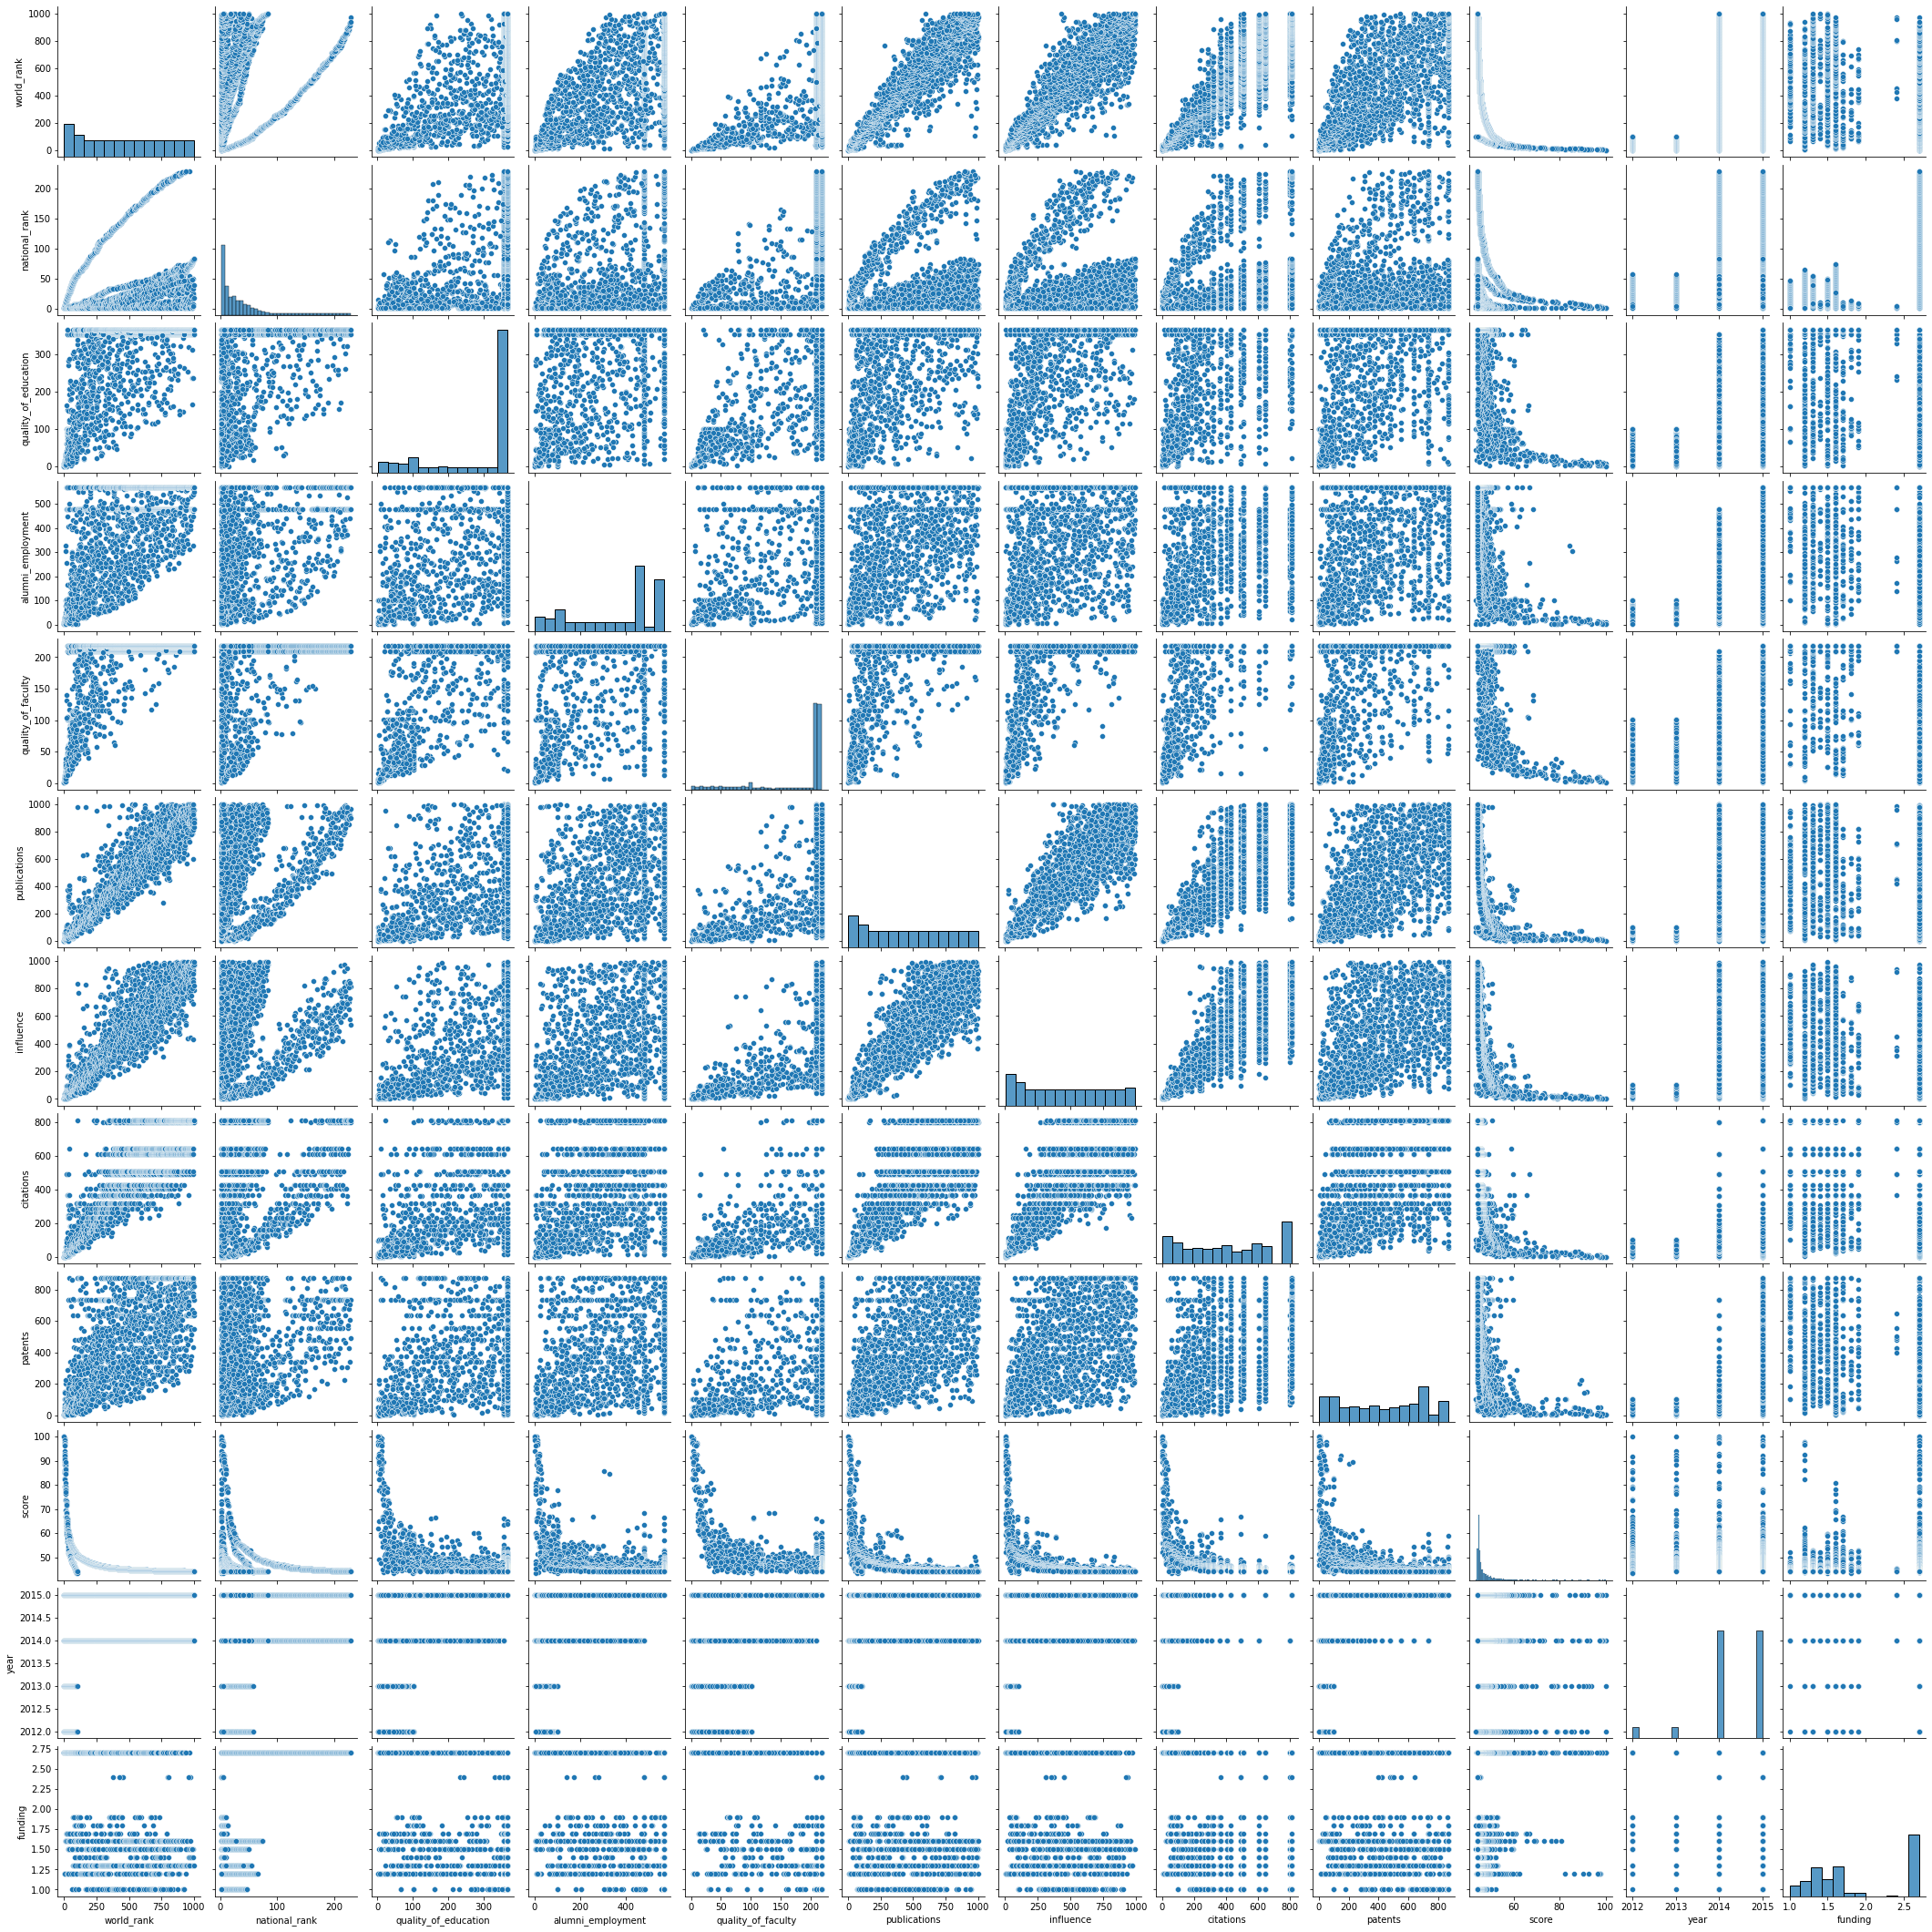

In [78]:
sns.pairplot(ranks_c)

<AxesSubplot:>

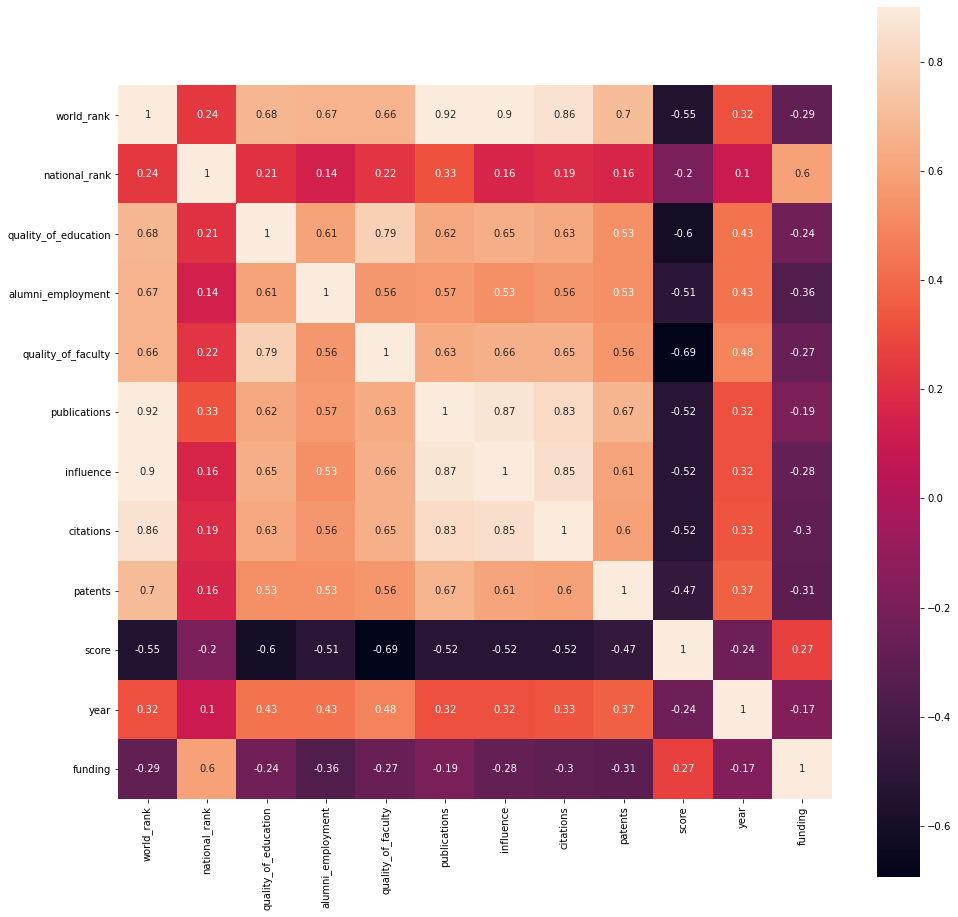

In [81]:
# view correlation matrix heatmap of all variables
plt.subplots(figsize=(16,16))
sns.heatmap(ranks_c.corr(), vmax=0.9, square=True, annot=True)

In [87]:
X = ranks_c.drop(["world_rank", "national_rank", "score", "institution", "country"], axis=1)
y = ranks_c["world_rank"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

In [88]:
param_tuning = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7],
    'n_estimators' : [100, 200, 500],
    'objective': ['reg:squarederror']
}

xgb_model = xgb.XGBRegressor()

search = RandomizedSearchCV(estimator = xgb_model,
                       param_distributions = param_tuning,
                       scoring = 'neg_mean_squared_error',
                       cv = 10)

search.fit(X_train, y_train)
model_xgb = search.best_estimator_

In [92]:
np.mean(np.sqrt(cross_val_score(model_xgb, X_test, y_test)))

0.9729257591557777

In [94]:
y_pred = model_xgb.predict(X_test)

In [95]:
r2_score(y_pred, y_test)

0.9568841082672681